# Blur & Roberts image filters


This example illustrate the use of `DataFlowTasks.jl` to parallelize the tiled
application of two kernels used in image processing. The application first
applies a blur filter on each pixel of the image; in a second step, the [Roberts
cross operator](https://en.wikipedia.org/wiki/Roberts_cross) is applied to
detect edges in the image.

Let us first load a test image:

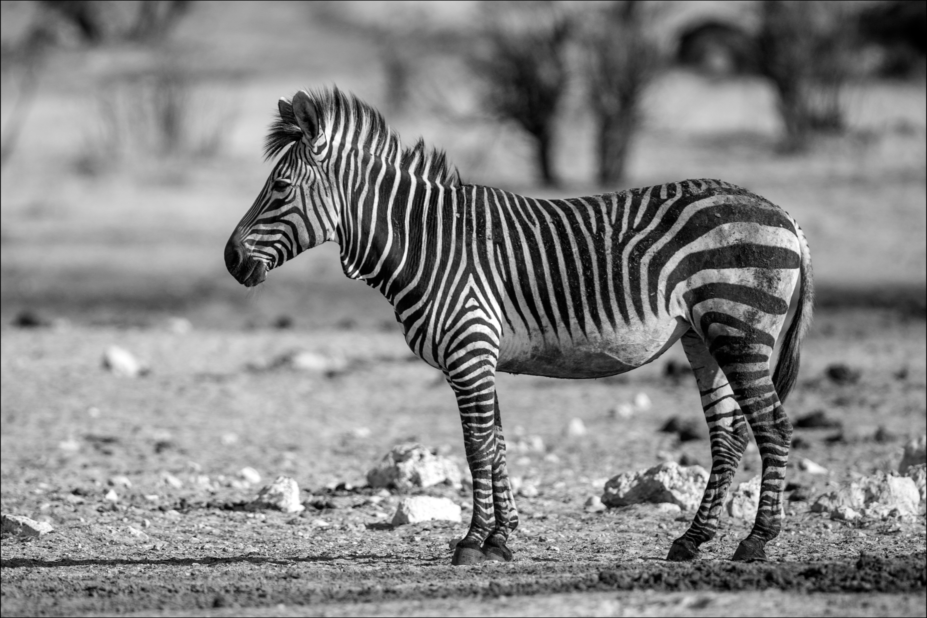

In [1]:
using Images
url = "https://upload.wikimedia.org/wikipedia/commons/c/c3/Equus_zebra_hartmannae_-_Etosha_2015.jpg"
ispath("test-image.jpg") || download(url, "test-image.jpg")
img = Gray.(load("test-image.jpg"))

We start by defining a few helper functions:

- the `contract` and `expand` functions manipulate ranges of indices in order to respectively contract or expand them by a few pixels;

- the `img2mat` and `mat2img` convert between a Gray-scale image and a matrix of
  floating-point pixel intensities. The filters will work on this latter
  representation, which may need a renormalization to be converted back to a
  Gray-scale image.

In [2]:
contract(range,n) = range[begin+n:end-n]
expand(range,n)   = range[begin]-n:range[end]-n

function img2mat(img)
    PixelType = eltype(img)
    mat = Float64.(img)
    return (PixelType, mat)
end

function mat2img(PixelType, mat)
    m1, m2 = extrema(mat)
    PixelType.((mat .- m1) ./ (m2-m1))
end

PixelType, mat = img2mat(img);

## Filters implementation

The `blur!` function averages the value of each pixel with the values of all
pixels less than `width` pixels away in manhattan distance. In order to simplify
the implementation, the filter is applied only to pixels that are sufficiently
far from the boundary to have all their neighbors correctly defined.

Results are written in-place in a pre-allocated `dest` array. Unless otherwise
specified, the filter is applied to the whole image, but can be reduced to a
tile if a smaller `range` argument is provided.

In [3]:
function blur!(dest, src; range=axes(src), width)
    ri, rj = intersect.(range, contract.(axes(src), width))

    weight = 1/(2*width+1)^2
    @inbounds for i in ri, j in rj
        dest[i,j] = 0
        for δi in -width:width, δj in -width:width
            dest[i,j] += src[i+δi, j+δi]
        end
        dest[i,j] *= weight
    end
end

blur! (generic function with 1 method)

In the following, we'll use a filter width of 5 pixels, which produces the
following results on the test image:

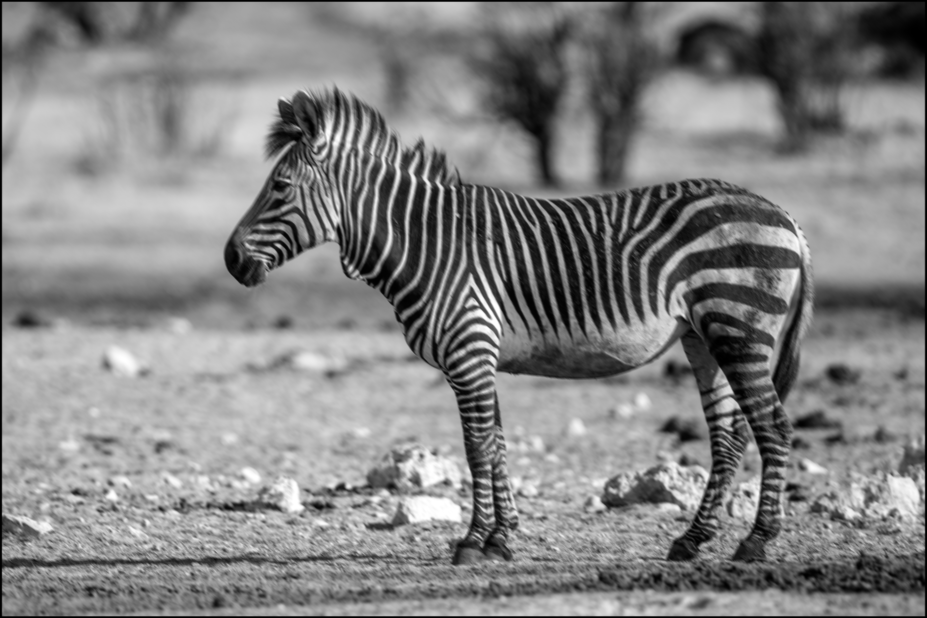

In [4]:
width = 5
blurred = similar(mat)

blur!(blurred, mat; width)

mat2img(PixelType, blurred)

The `roberts!` function applies the Roberts cross operator to the provided
image. Like above, it operates by default on all pixels in the image (provided
they are sufficiently far from the boundaries), but can be restricted to work on
a tile if the `range` argument is provided.

In [5]:
function roberts!(dest, src; range=axes(src))
    ri, rj = intersect.(range, contract.(axes(src), 1))

    for i in ri, j in rj
        dest[i,j] = (
            + (sqrt(src[i,  j]) - sqrt(src[i+1,j+1]))^2
            + (sqrt(src[i+1,j]) - sqrt(src[i  ,j+1]))^2
        )^(0.25)
    end
end

roberts! (generic function with 1 method)

Applying this edge detection filter on the original image produces the following results:

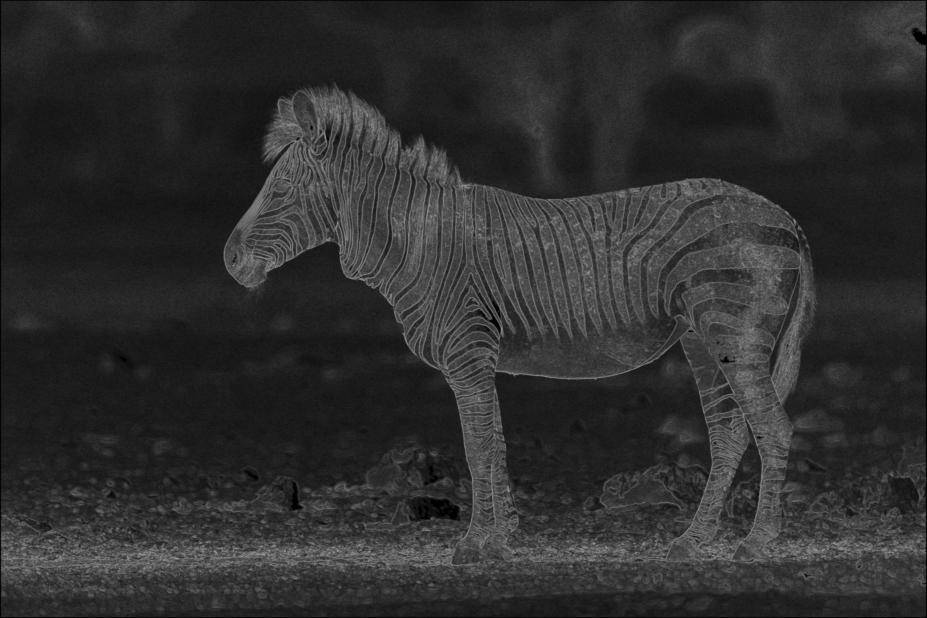

In [6]:
contour = similar(mat)
roberts!(contour, mat)

mat2img(PixelType, contour)

Chaining the blur and roberts filters may make edge detection less noisy:

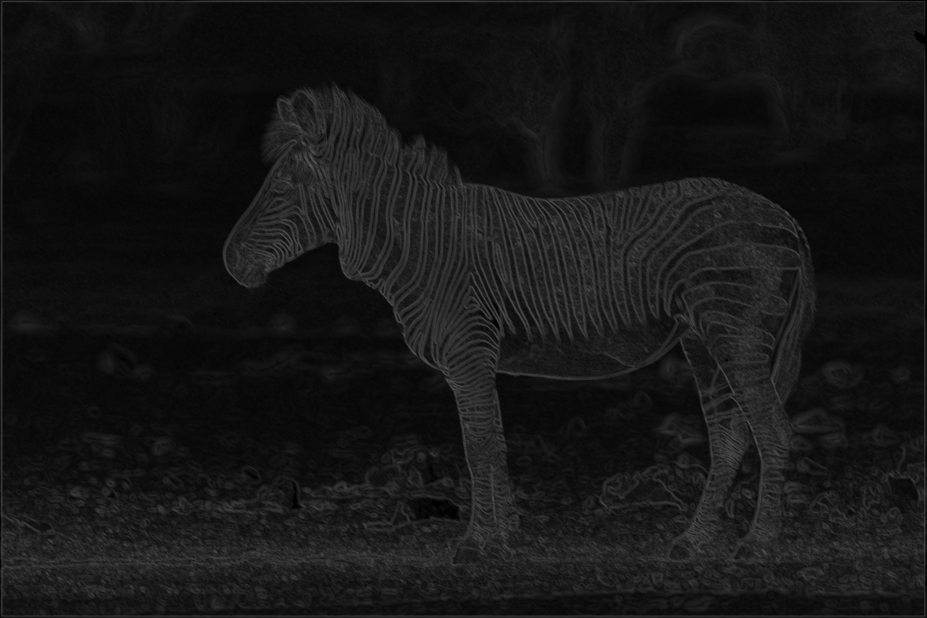

In [7]:
function blur_roberts!(img; width, tmp=similar(img))
    blur!(tmp, img; width)
    roberts!(img, tmp)
end

mat1 = copy(mat)
tmp  = similar(mat)

blur_roberts!(mat1; width, tmp)
mat2img(PixelType, mat1)

## Tiled filter application

The [`TiledIteration.jl`](https://github.com/JuliaArrays/TiledIteration.jl)
package implements various tools allowing to define and iterate over disjoint
tiles of a larger array. We'll use it to apply the filters tile by tile.

The `map_tiled!` higher-order function automates the application of a filter
`fun!` on all pixels of an image `src` decomposed with a tilesize `ts`. This
higher-order function is then used to defined tiled versions of the blur and
roberts filters.

In [8]:
using TiledIteration

function map_tiled!(fun!, dest, src, ts)
    for tile in TileIterator(axes(src), (ts, ts))
        fun!(dest, src, tile)
    end
end

blur_tiled!(dest, src, ts; width) = map_tiled!(dest, src, ts) do dest, src, tile
    blur!(dest, src; width, range=tile)
end

roberts_tiled!(dest, src, ts) = map_tiled!(dest, src, ts) do dest, src, tile
    roberts!(dest, src; range=tile)
end

function blur_roberts_tiled!(img, ts; width, tmp=similar(img))
    blur_tiled!(tmp, img, ts; width)
    roberts_tiled!(img, tmp, ts)
end

blur_roberts_tiled! (generic function with 1 method)

Decomposing the original image in tiles of size $512\times 512$, the tiled
application of the filters yields the same result as above, in a more
cache-efficient way:

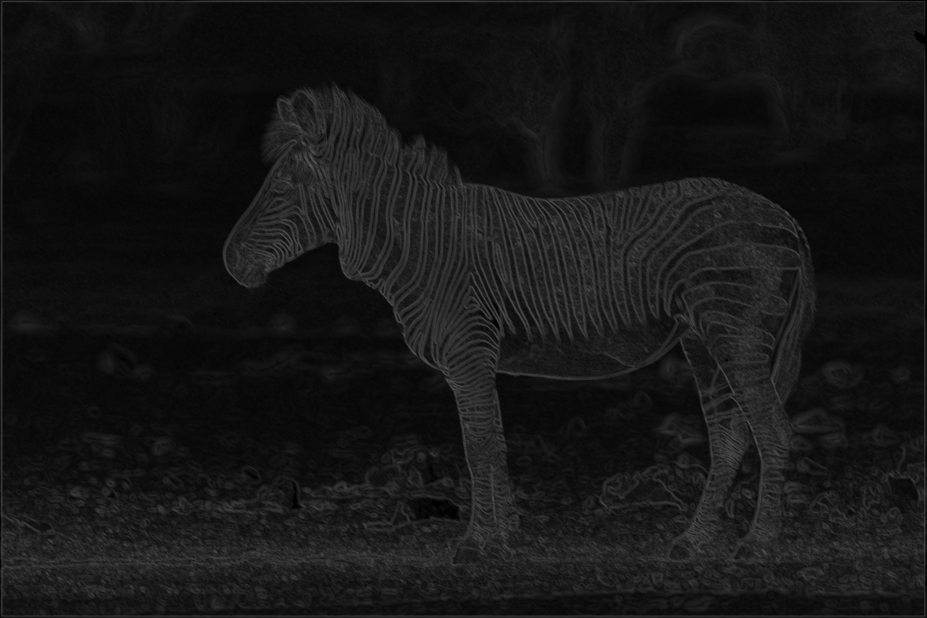

In [9]:
ts = 512

mat1 .= mat
blur_roberts_tiled!(mat1, ts; width, tmp)

mat2img(PixelType, mat1)

## Parallel filter application

Parallelizing the tiled filter application is relatively straightforward using
`DataFlowTasks.jl`. As usual, it involves specifying which data is accessed by
each task.

In [10]:
using DataFlowTasks
using DataFlowTasks: @spawn

function blur_dft!(dest, src, ts; width)
    map_tiled!(dest, src, ts) do dest, src, tile
        outer = intersect.(expand.(tile, width), axes(src))
        @spawn begin
            @R view(src, outer...)
            @W view(dest, tile...)
            blur!(dest, src; width, range=tile)
        end label="blur ($tile)"
    end
    @spawn @R(dest) label="blur (result)"
end

function roberts_dft!(dest, src, ts)
    map_tiled!(dest, src, ts) do dest, src, tile
        outer = intersect.(expand.(tile, 1), axes(src))
        @spawn begin
            @R view(src, outer...)
            @W view(dest, tile...)
            roberts!(dest, src; range=tile)
        end label="roberts ($tile)"
    end
    @spawn @R(dest) label="roberts (result)"
end

roberts_dft! (generic function with 1 method)

Note how each filter spawns one task for each tile, and an extra task to get the
results in the end. This allows applying a given filter independently of the
other.

However, the filters remain composable: when applying both filters one after the
other, no implicit synchronization is enforced at the end of the blurring stage,
and the runtime may decide to intersperse blurring and roberts tasks (as long as
the blurring of a tile and all its neighbors is performed before the application
of the roberts filter on this tile).

In [11]:
function blur_roberts_dft!(img, ts; width, tmp=similar(img))
    blur_dft!(tmp, img, ts; width)
    roberts_dft!(img, tmp, ts)
    @spawn @R(img) label="result"
end

blur_roberts_dft! (generic function with 1 method)

Again this yields the same results on the test image:

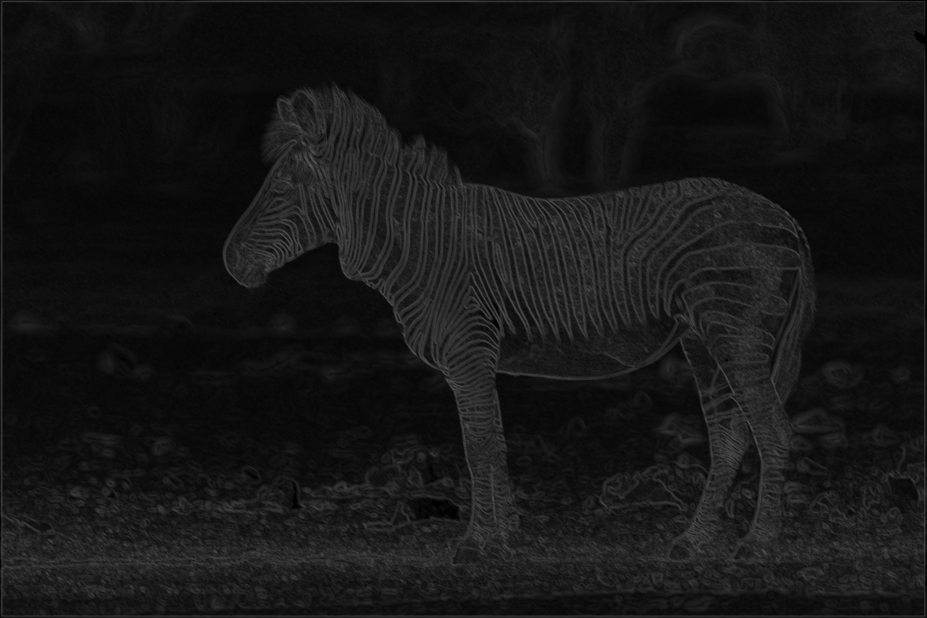

In [12]:
mat1 .= mat;
blur_roberts_dft!(mat1, ts; width, tmp) |> wait

mat2img(PixelType, mat1)

## Profiling the parallel version

As usual, profiling data should be collected in a context that is as clean as possible.

In [13]:
GC.gc()

mat1 .= mat;
log_info = DataFlowTasks.@log wait(blur_roberts_dft!(mat1, ts; width, tmp))

LogInfo with 83 logged tasks
	 critical time: 4.7 seconds

The parallel trace shows how blur and roberts tasks are interspersed in the time line:

Status `~/.julia/scratchspaces/d1549cb6-e9f4-42f8-98cc-ffc8d067ff5b/weakdeps-1.9/Project.toml`
  [13f3f980] CairoMakie v0.10.11
  [e9467ef8] GLMakie v0.8.11
  [f526b714] GraphViz v0.2.0
  [ee78f7c6] Makie v0.19.11
[ Info: Computing    : 119.55394853
[ Info: Inserting    : 0.0004810940000000001
[ Info: Other        : 1.6725180477337613


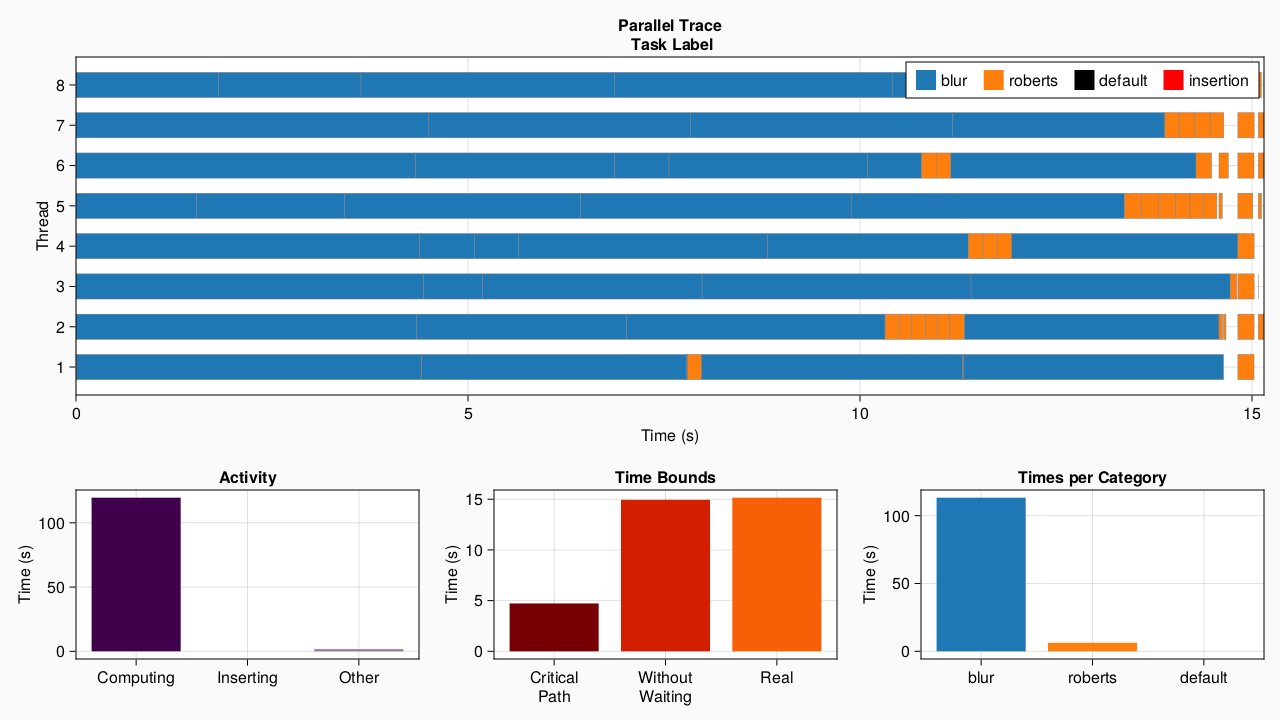

In [14]:
DataFlowTasks.stack_weakdeps_env!()
using CairoMakie

trace = plot(log_info, categories=["blur", "roberts"])

In terms of performance, elapsed time seems to be bounded in this case by the
total computing time of all threads. Re-running the same computation with more
threads may help reduce the overall wall-clock time.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*